# Libraries

In [21]:
# Data manipulation and helpful libraries
import numpy as np 
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import itertools
#from IPython.display import Image, display
import cv2
import seaborn as sns
from PIL import Image

# Machine Learning libraries
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Loading dataset

In [2]:
# Data main directory
dataset_dir = "/kaggle/input/mango-leaf-disease-dataset"
data = []
labels = []

for fold in os.listdir(dataset_dir):
    # Save the subfold names as labels 
    filepaths = os.path.join(dataset_dir, fold)
    for file in os.listdir(filepaths):
        # Save the data path
        data.append(os.path.join(filepaths,file))
        labels.append(fold)

# Convert to a pandas dataframe 
data_ = pd.Series(data, name='paths')
labels_ = pd.Series(labels, name = 'labels')
dataset = pd.concat([data_, labels_], axis=1)

In [3]:
dataset.head()

,paths,labels
0,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
1,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
2,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
3,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
4,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew


## Splitting the data

In [4]:
training_data, temp_validation_data = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=42, stratify=dataset['labels'])
validation_data, test_data = train_test_split(temp_validation_data, test_size=0.05, shuffle=True, random_state=42, stratify=temp_validation_data['labels'])
print(f"Dimension of the training data: {training_data.shape[0]}")
print(f"Dimension of the validation data: {validation_data.shape[0]}")
print(f"Dimension of the test data: {test_data.shape[0]}")

Dimension of the training data: 3200
Dimension of the validation data: 760
Dimension of the test data: 40


## Preparing the data

In [5]:
# Batch size
batch_size = 32
# Dataset image shape
img_shape = (224, 224)

# The original dataset was augmentated
# This function only returns the image as is
def return_image(image):
    return image

# Create a ImageDataGenerator
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)

# Reading the images
training_data_gen = train_gen.flow_from_dataframe(training_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )
validation_data_gen = train_gen.flow_from_dataframe(validation_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )



Found 3200 validated image filenames belonging to 8 classes.
Found 760 validated image filenames belonging to 8 classes.


# Define the model

In [6]:
# The model
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=2, data_format='channels_last')(inputs)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(4,4))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=1)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(units=8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model_name = "model.h5"
# Define callback function
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
# Stopping parameters
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
# Learning rate changes during training
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 111, 111, 32)      1568      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 111, 111, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 26, 26, 32)        0         
                                                             

# Training the model

In [7]:
history = model.fit(training_data_gen,
                    validation_data=validation_data_gen,
                    epochs=50,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 1.5479 - accuracy: 0.4994
Epoch 1: val_loss improved from inf to 3.59013, saving model to model.h5
100/100 [==============================] - 12s 86ms/step - loss: 1.5479 - accuracy: 0.4994 - val_loss: 3.5901 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.8796 - accuracy: 0.6869
Epoch 2: val_loss improved from 3.59013 to 1.71351, saving model to model.h5
100/100 [==============================] - 8s 80ms/step - loss: 0.8796 - accuracy: 0.6869 - val_loss: 1.7135 - val_accuracy: 0.4974 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.7784
Epoch 3: val_loss improved from 1.71351 to 1.22271, saving model to model.h5
100/100 [==============================] - 8s 78ms/step - loss: 0.6476 - accuracy: 0.7784 - val_loss: 1.2227 - val_accuracy: 0.6053 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.8272
Epoch 4: val_loss did not improve from 1.22271
100/100 [==============================] - 8s 84ms/step - loss: 0.5072 - accuracy: 0.8272 - val_loss: 1.4326 - val_accuracy: 0.5711 - lr: 1.0000e-04
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.417

# Plot training results

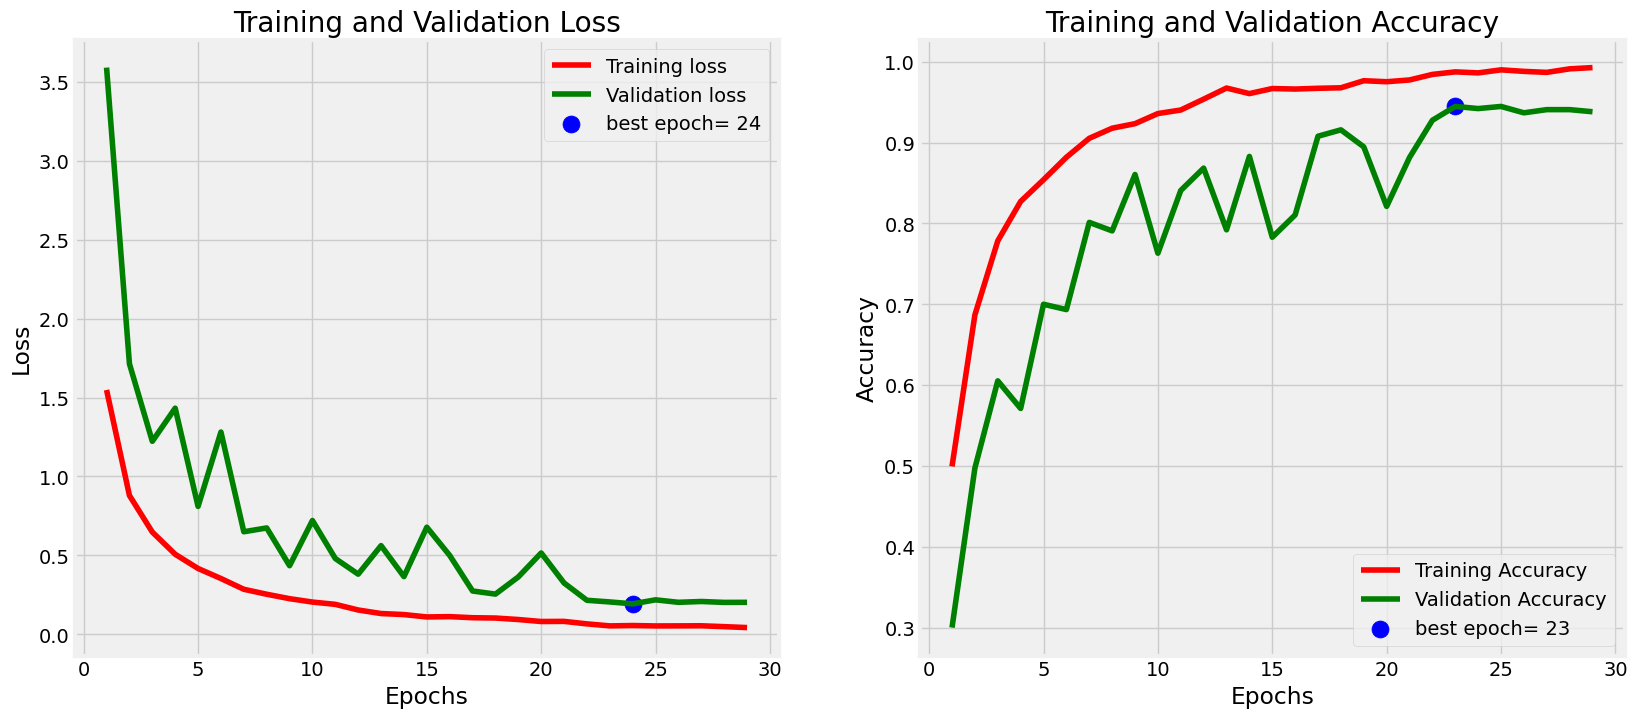

In [8]:
training_acc = history.history['accuracy']
training_loss = history.history['loss']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# Select the min loss and the max accuracy achieved in the validation
index_loss = np.argmin(validation_loss)
val_lowest = validation_loss[index_loss]
index_acc = np.argmax(validation_acc)
acc_highest = validation_acc[index_acc]

# Arrange for plotting
epochs = [i+1 for i in range(len(training_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'r', label= 'Training loss')
plt.plot(epochs, validation_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, validation_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Testing the model

Found 40 validated image filenames belonging to 8 classes.
2/2 [==============================] - 0s 102ms/step


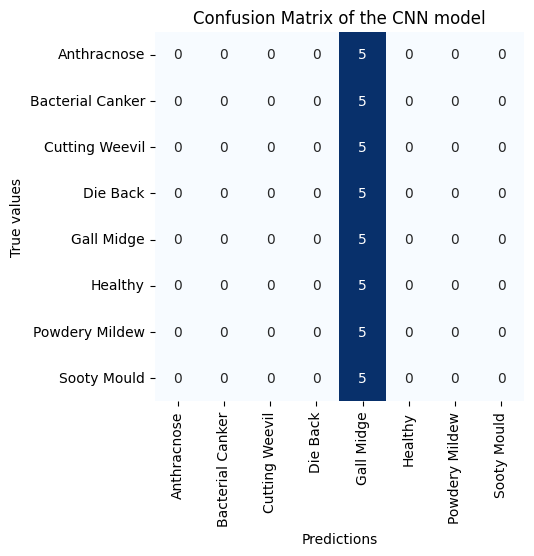

                  precision    recall  f1-score   support

     Anthracnose       0.00      0.00      0.00         5
Bacterial Canker       0.00      0.00      0.00         5
  Cutting Weevil       0.00      0.00      0.00         5
        Die Back       0.00      0.00      0.00         5
      Gall Midge       0.12      1.00      0.22         5
         Healthy       0.00      0.00      0.00         5
  Powdery Mildew       0.00      0.00      0.00         5
     Sooty Mould       0.00      0.00      0.00         5

        accuracy                           0.12        40
       macro avg       0.02      0.12      0.03        40
    weighted avg       0.02      0.12      0.03        40



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
plt.style.use('default')
# Define ImageDataGenerator and normalize
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image, rescale=1./255)

# Reading the images
test_data_gen = test_gen.flow_from_dataframe(test_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )
# Predict
preds = model.predict(test_data_gen)
# Select the max argument for each predictions
y_pred = np.argmax(preds, axis=1)

# Get classes names and mapping
g_dict = test_data_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_data_gen.classes, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of the CNN model')
plt.show()

# Classification report
print(classification_report(test_data_gen.classes, y_pred, target_names= classes))

Unless the model had good performance in the training and validation, with the test data had bad performance. This is an indication of the model needs more data in order to generalize and have a good balance in interclasses differentiation

# Grad-CAM

In [35]:
def get_img_array(img_path, img_shape):
    # Load image
    img = tf.keras.utils.load_img(img_path, target_size=img_shape) 
    # Convert to array
    array = tf.keras.utils.img_to_array(img) / 255.0    
    # Add a dimension to the array image
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )    

    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)    

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalizing the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img) 
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    return superimposed_img

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))

## Display a sample of the test images

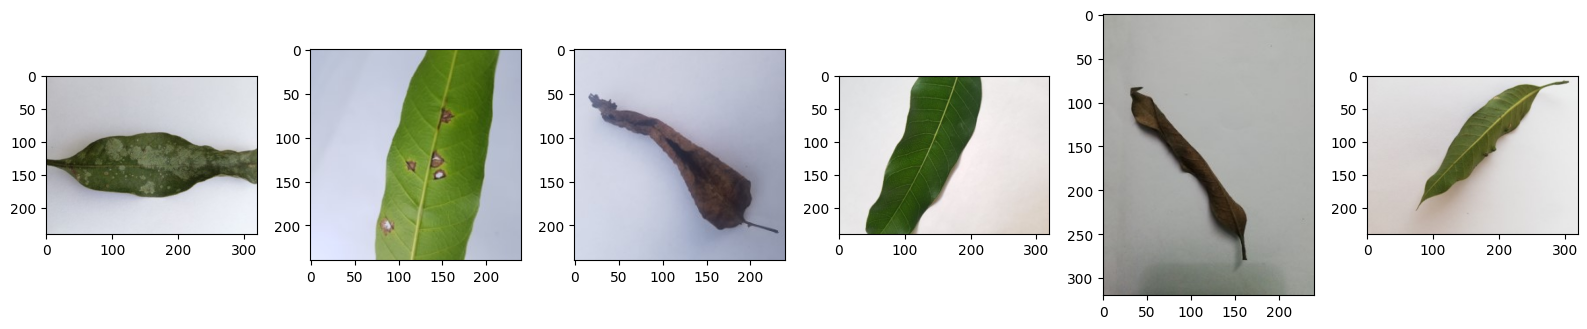

In [89]:
fig, axs = plt.subplots(1,6, figsize=(16,12))
axs[0].imshow(Image.open(test_data.iloc[0,0]))
axs[1].imshow(Image.open(test_data.iloc[1,0]))
axs[2].imshow(Image.open(test_data.iloc[2,0]))
axs[3].imshow(Image.open(test_data.iloc[3,0]))
axs[4].imshow(Image.open(test_data.iloc[4,0]))
axs[5].imshow(Image.open(test_data.iloc[5,0]))
plt.tight_layout()
plt.show()

### Perform grad-CAM

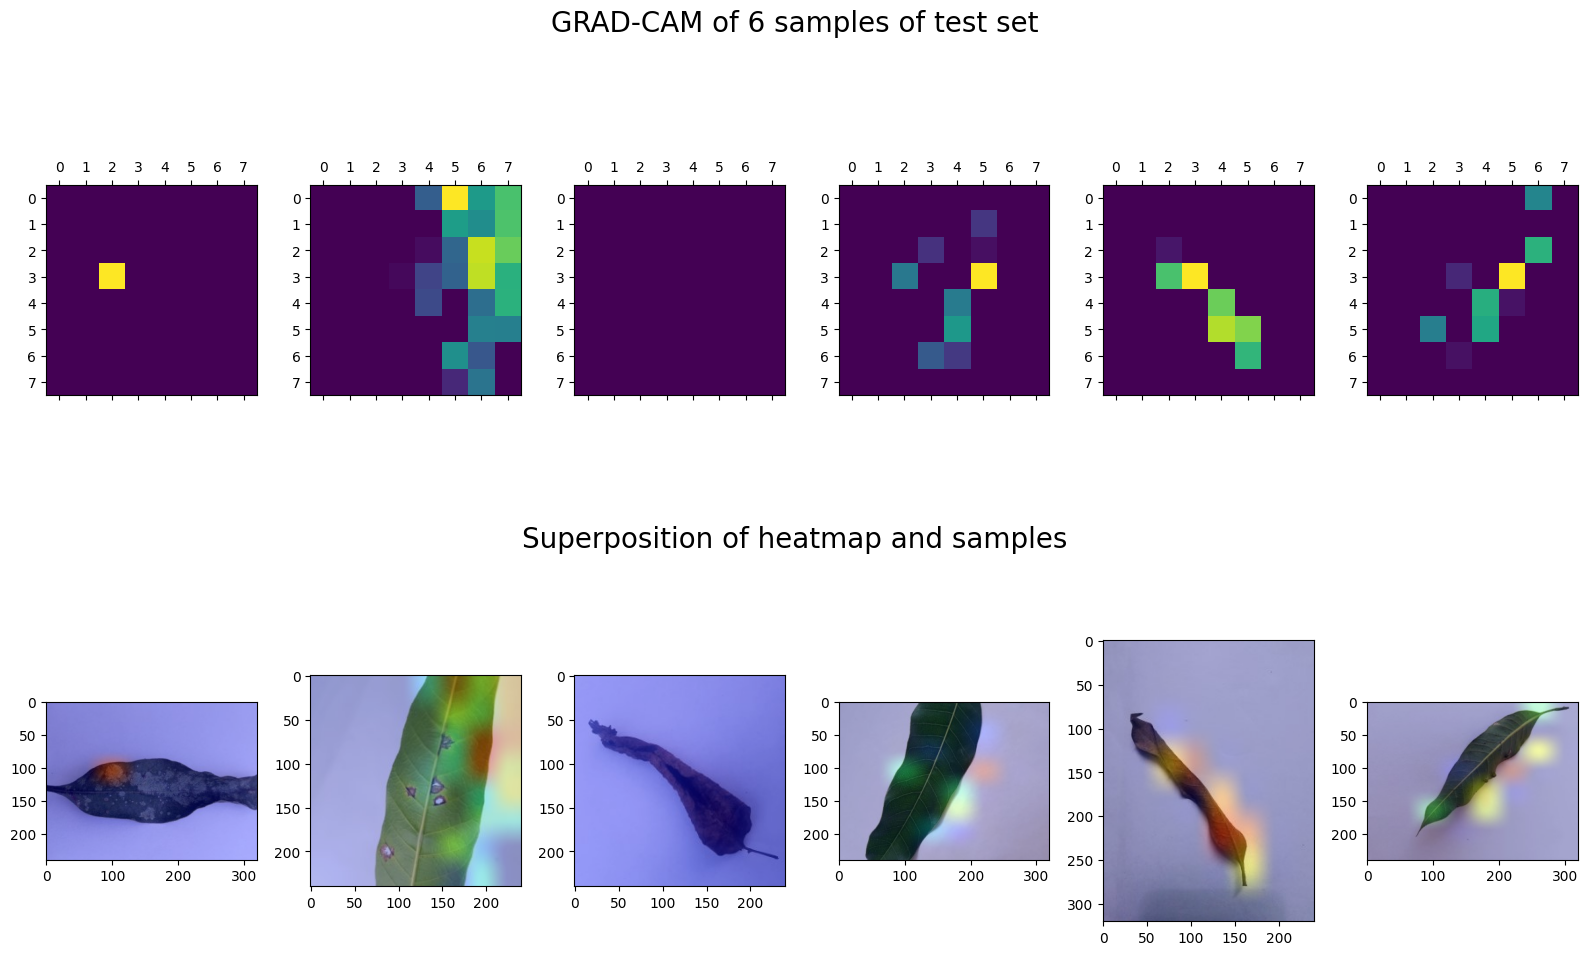

In [81]:
last_conv_layer_name = "max_pooling2d_1"
fig, ax = plt.subplots(2,6, figsize=(16,12))

for i in range(6):
    img_array = get_img_array(test_data.iloc[i,0], img_shape=img_shape)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    ax[0,i].matshow(heatmap)
    # Superpose image and heatmap
    ax[1,i].imshow(display_gradcam(test_data.iloc[i,0], heatmap))


plt.tight_layout()
fig.text(0.5, 0.92, "GRAD-CAM of 6 samples of test set", ha='center', fontsize=20)
fig.text(0.5, 0.49, "Superposition of heatmap and samples", ha='center', fontsize=20)
plt.show()

### 

# Deep feature using VGG16

## Rearrange the data

In [61]:
# Loading dataset
def load_dataset(folder, img_size=(224, 224)):
    images = []
    labels = []
    for label in os.listdir(folder):
        file_path = os.path.join(folder, label)
        if os.path.isdir(file_path):
            for file in os.listdir(file_path):
                img_path = os.path.join(file_path, file)
                # Read image
                image = cv2.imread(img_path)
                # Convert from BGR color space to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Resize image
                image = cv2.resize(image, img_size)
                images.append(image)
                labels.append(label)
    # Converting to numpy array
    return np.array(images), np.array(labels)
dataset_path="/kaggle/input/mango-leaf-disease-dataset"

X, y = load_dataset(dataset_path)

## Split the data

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define the model

In [63]:
# Load base pretrained VGG16 model
base_model = tf.keras.applications.VGG16(
                                          include_top= False,
                                          weights= "imagenet",
                                          input_shape= (224,224,3)

)

58889256/58889256 [==============================] - 2s 0us/step


In [64]:
# Freezing weights of base model
base_model.trainable = False
# Creating Sequential Model
deep_feat_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256,
                          kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),
                          activity_regularizer = tf.keras.regularizers.l1(0.006),
                         bias_regularizer = tf.keras.regularizers.l1(0.006),
                         activation= "linear"
                         )    
    ])

## Extracting features for each set of data

In [65]:
train_features = deep_feat_model.predict(X_train)
test_features = deep_feat_model.predict(X_test)

25/25 [==============================] - 3s 122ms/step


In [66]:
train_features.shape

(3200, 7, 7, 256)

## Reshaping extracted features

In [67]:
training_flatten = train_features.reshape(train_features.shape[0], -1)
test_flatten = test_features.reshape(test_features.shape[0], -1)

# Baseline model classifier

# KNN model

In [68]:
knn_model = KNeighborsClassifier()
knn_model.fit(training_flatten, y_train)

KNeighborsClassifier()

### Predict data

In [69]:
y_pred = knn_model.predict(test_flatten)

### Result metrics

                  precision    recall  f1-score   support

     Anthracnose       0.96      0.38      0.55       112
Bacterial Canker       0.91      0.99      0.95       101
  Cutting Weevil       0.99      1.00      0.99        86
        Die Back       0.52      1.00      0.68        93
      Gall Midge       0.86      0.79      0.82        90
         Healthy       0.72      0.96      0.82        91
  Powdery Mildew       0.88      0.81      0.84       123
     Sooty Mould       1.00      0.58      0.73       104

        accuracy                           0.80       800
       macro avg       0.85      0.81      0.80       800
    weighted avg       0.86      0.80      0.79       800



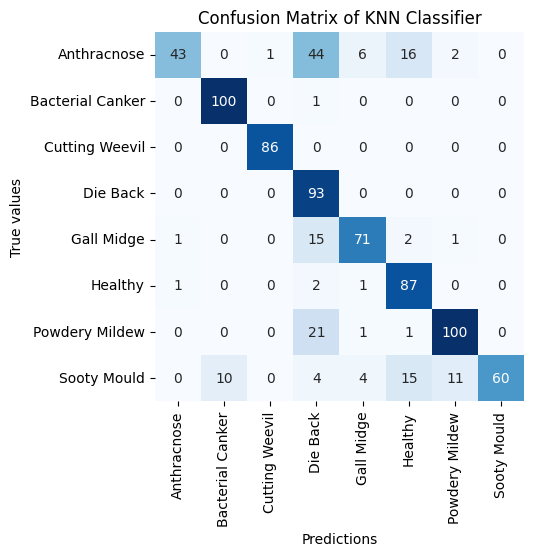

In [70]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix for each class
class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of KNN Classifier')
plt.show()

# Comparison models

### Support Vector Machine model

                  precision    recall  f1-score   support

     Anthracnose       0.96      1.00      0.98       112
Bacterial Canker       0.99      0.98      0.99       101
  Cutting Weevil       1.00      1.00      1.00        86
        Die Back       0.98      0.99      0.98        93
      Gall Midge       0.98      0.94      0.96        90
         Healthy       0.98      0.98      0.98        91
  Powdery Mildew       1.00      0.96      0.98       123
     Sooty Mould       0.96      0.99      0.98       104

        accuracy                           0.98       800
       macro avg       0.98      0.98      0.98       800
    weighted avg       0.98      0.98      0.98       800



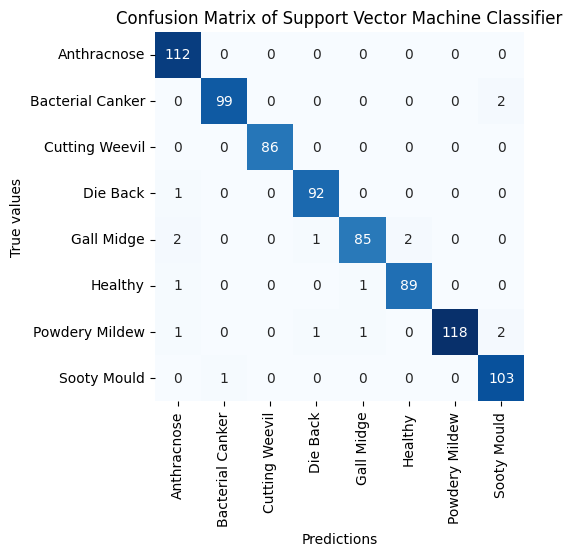

In [72]:
from sklearn.svm import SVC
svm_model = SVC()
# Fit model
svm_model.fit(training_flatten, y_train)
# Predict
y_pred_svm = svm_model.predict(test_flatten)
# Classification report
print(classification_report(y_test, y_pred_svm))
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of Support Vector Machine Classifier')
plt.show()